In [17]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Load the data
final_df = pd.read_feather('../data_results/final_df.ftr')

Let's start with a Kaplan Meier plot

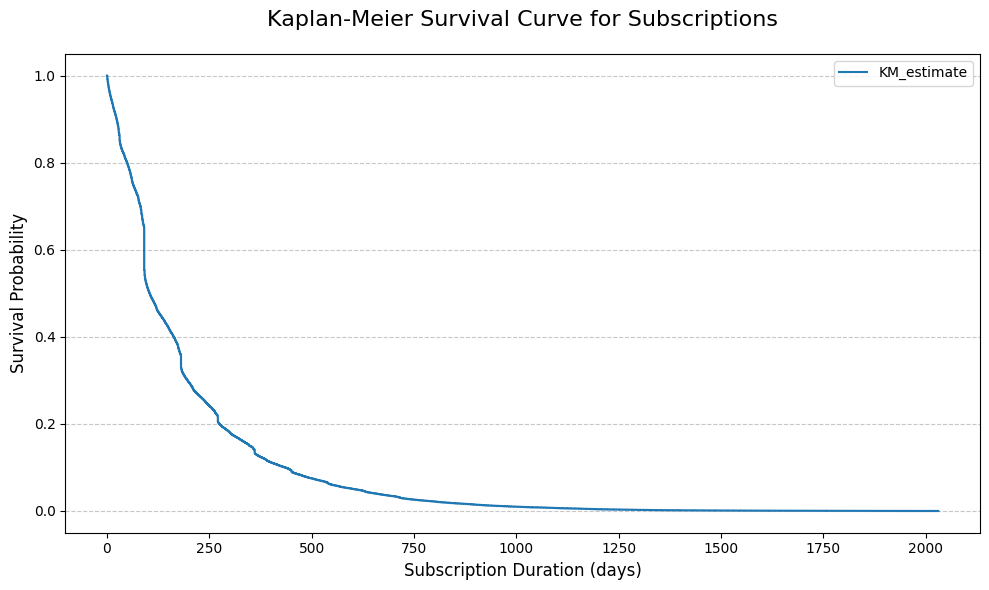

In [ ]:
# Instantiate Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Define yearly cohorots for KM
final_df["cohort"] = final_df["from_date"].dt.year

# Fit the Kaplan-Meier model
kmf.fit(
    durations=final_df["subscription_duration"],  # Subscription durations
    event_observed=~final_df["censored"]  # Convert censored column to event observed
)

# Plot the survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=True)  # Show confidence intervals

# Aesthetic improvements
plt.title("Kaplan-Meier Survival Curve for Subscriptions", fontsize=16, pad=20)
plt.xlabel("Subscription Duration (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


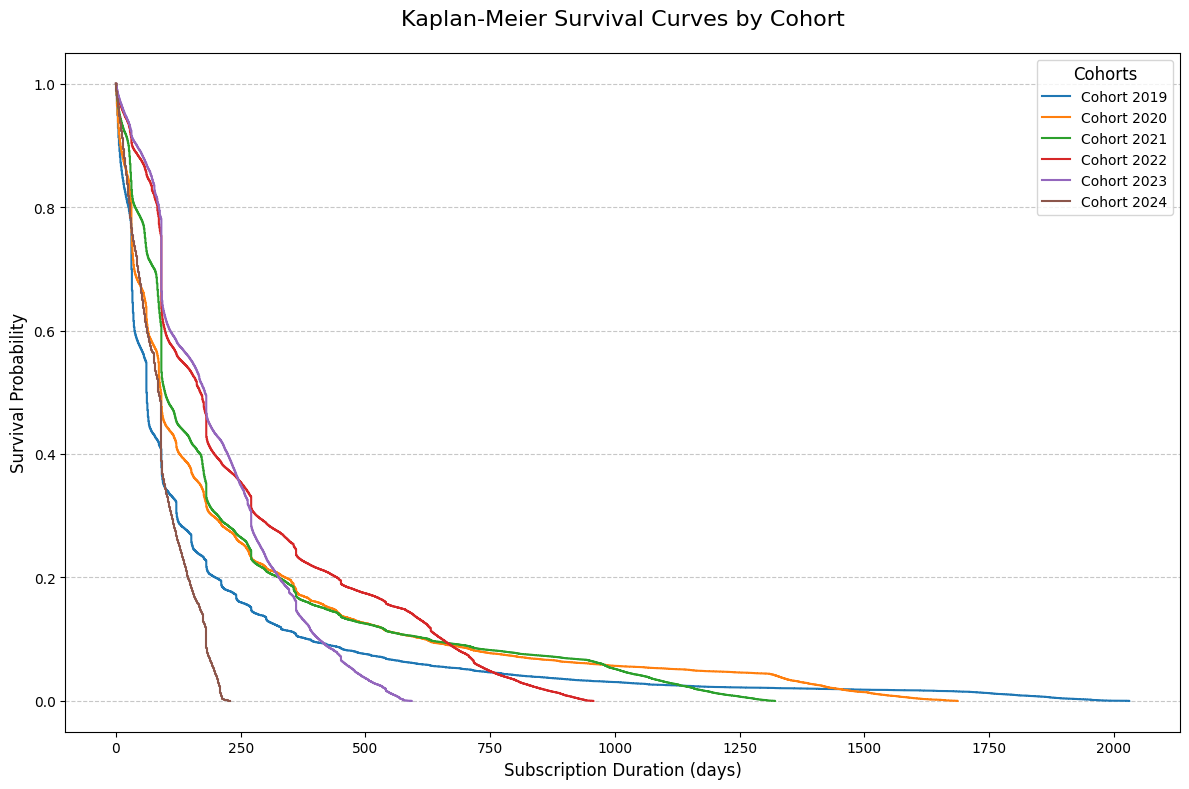

In [26]:
# Instantiate Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate through each cohort and fit Kaplan-Meier
for cohort, cohort_data in final_df.groupby("cohort"):
    kmf.fit(
        durations=cohort_data["subscription_duration"],
        event_observed=~cohort_data["censored"],
        label=f"Cohort {cohort}"
    )
    kmf.plot_survival_function(ci_show=False)  # Disable confidence intervals for clarity

# Aesthetic improvements
plt.title("Kaplan-Meier Survival Curves by Cohort", fontsize=16, pad=20)
plt.xlabel("Subscription Duration (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.legend(title="Cohorts", fontsize=10, title_fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Now let's plot the retention table

/tmp/ipykernel_11410/1299213846.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  lambda row: pd.date_range(row['from_date'], row['to_date'], freq='Q'), axis=1
/tmp/ipykernel_11410/1299213846.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_expanded['cohort'] = df_expanded.groupby('subscription_id')['active_quarter'].transform('min')


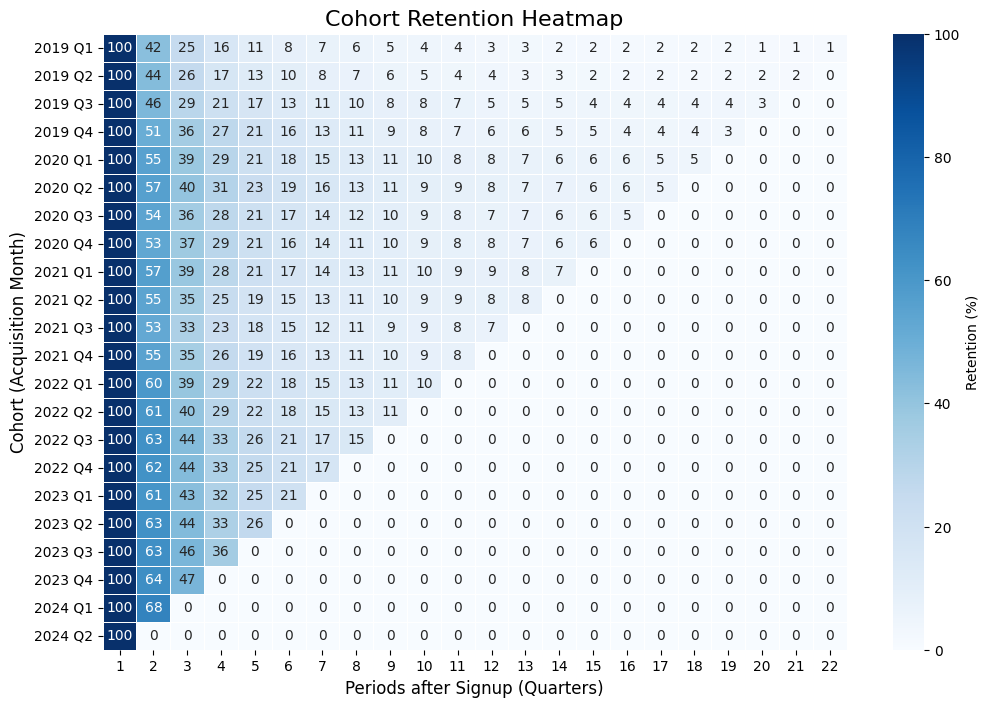

In [45]:
# One row for each quarter the customer was active
all_quarters = final_df.apply(
    lambda row: pd.date_range(row['from_date'], row['to_date'], freq='Q'), axis=1
)
df_expanded = final_df.loc[final_df.index.repeat(all_quarters.str.len())]
df_expanded['active_quarter'] = np.concatenate(all_quarters.to_numpy())

# Assign cohorts based on the first active month
df_expanded['cohort'] = df_expanded.groupby('subscription_id')['active_quarter'].transform('min')

# Calculate cohort index (months since acquisition)
df_expanded['cohort_index'] = (
    (df_expanded['active_quarter'].dt.year - df_expanded['cohort'].dt.year) * 4 +
    (df_expanded['active_quarter'].dt.quarter - df_expanded['cohort'].dt.quarter)
)

# Group data by cohort and cohort_index to count unique customers
cohort_data = (
    df_expanded.groupby(['cohort', 'cohort_index'])['subscription_id']
    .nunique()
    .unstack(1)
)

# Normalize retention as a percentage of the cohort size at month 0
cohort_sizes = cohort_data.iloc[:, 0]  # Size of each cohort at time 0
retention = cohort_data.divide(cohort_sizes, axis=0) * 100

# Replace NaN values with 0
retention = retention.fillna(0)

# Plot the heatmap
fig = plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    retention,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    cbar_kws={'label': 'Retention (%)'},
    linewidths=0.5
)

plt.title("Cohort Retention Heatmap", fontsize=16)
plt.xlabel("Periods after Signup (Quarters)", fontsize=12)
plt.ylabel("Cohort (Acquisition Month - Subscription)", fontsize=12)

# Adjust labels
quarter_labels = [f"{i + 1}" for i in range(retention.shape[1])]
ax.set_xticklabels(quarter_labels)

cohort_labels = retention.index.to_series().apply(lambda x: f"{x.year} Q{x.quarter}" if hasattr(x, 'quarter') else str(x))
ax.set_yticklabels(cohort_labels)

plt.xticks(rotation=0)
plt.show()


In [88]:
retention.to_feather('../data_results/retention.ftr')

Get table of churn

In [76]:
# Get the start and end of each month in the dataset
min_date = final_df['from_date'].min()
max_date = final_df['to_date'].max()
months = pd.date_range(min_date.replace(day=1), max_date, freq='MS').to_period('M')

# Initialize the summary table dictionary
summary_dict = {
    "Metric": ["Existing Subscriptions", "New Subscriptions", "Cancelled Subscriptions", "Total Subscriptions"]
}

# Loop through each month and calculate metrics
for month in months:
    # Convert period to datetime for filtering
    month_start = month.start_time
    month_end = month.end_time
    
    # Existing Subscriptions (active at the beginning of the month)
    existing_subscriptions = final_df[(final_df['from_date'] < month_start) & (final_df['to_date'] >= month_start)]
    
    # New Subscriptions (started in the month)
    new_subscriptions = final_df[(final_df['from_date'] >= month_start) & (final_df['from_date'] <= month_end)]
    
    # Cancelled Subscriptions (ended in the month)
    cancelled_subscriptions = final_df[(final_df['to_date'] >= month_start) & (final_df['to_date'] <= month_end)]
    
    # Total Subscriptions (active at the end of the month)
    total_subscriptions = final_df[(final_df['from_date'] <= month_end) & (final_df['to_date'] > month_end)]
    
    # Append the counts to the dictionary
    summary_dict[str(month)] = [
        len(existing_subscriptions),
        len(new_subscriptions),
        len(cancelled_subscriptions),
        len(total_subscriptions)
    ]

# Convert dictionary to DataFrame
summary_df_q = pd.DataFrame(summary_dict)

# Set the Metric column as index
summary_df_q.set_index("Metric", inplace=True)

# Print the summary table
print(summary_df_q)

                         2019-01  2019-02  2019-03  2019-04  2019-05  2019-06  2019-07  2019-08  2019-09  2019-10  2019-11  2019-12  2020-01  2020-02  2020-03  2020-04  2020-05  2020-06  2020-07  2020-08  2020-09  2020-10  2020-11  2020-12  2021-01  2021-02  2021-03  2021-04  2021-05  2021-06  2021-07  2021-08  2021-09  2021-10  2021-11  2021-12  2022-01  2022-02  2022-03  2022-04  2022-05  2022-06  2022-07  2022-08  2022-09  2022-10  2022-11  2022-12  2023-01  2023-02  2023-03  2023-04  2023-05  2023-06  2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  2024-01  2024-02  2024-03  2024-04  2024-05  2024-06  2024-07  2024-08
Metric                                                                                                                                                                                                                                                                                                                                                                      

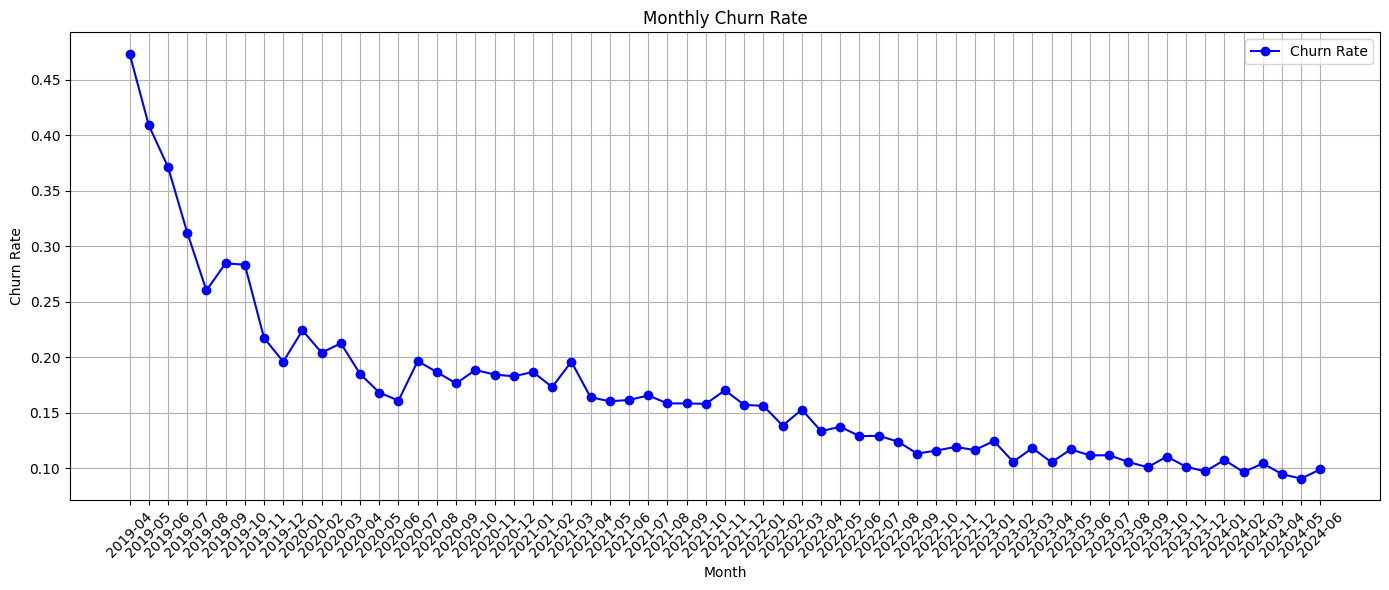

In [85]:
# Calculate churn rate for each month
churn_rates = []

for month in months:
    # Convert period to datetime for filtering
    month_start = month.start_time
    month_end = month.end_time
    
    # Total Subscriptions at the start of the month (active from the previous month)
    total_subscriptions_start = final_df[(final_df['from_date'] < month_start) & (final_df['to_date'] >= month_start)]
    
    # Cancelled Subscriptions during the month
    cancelled_subscriptions = final_df[(final_df['to_date'] >= month_start) & (final_df['to_date'] <= month_end)]
    
    # Calculate churn rate
    churn_rate = len(cancelled_subscriptions) / len(total_subscriptions_start) if len(total_subscriptions_start) > 0 else 0
    churn_rates.append(churn_rate)

# Plot churn rate
plt.figure(figsize=(14, 6))
plt.plot(months[3:-2].astype(str), churn_rates[3:-2], marker='o', color='b', label='Churn Rate') # delete initial and final months for clarity
plt.xlabel('Month')
plt.ylabel('Churn Rate')
plt.title('Monthly Churn Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

/tmp/ipykernel_11410/349354793.py:8: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(final_df['from_date'].min(), final_df['to_date'].max(), freq='Q').to_period('Q')


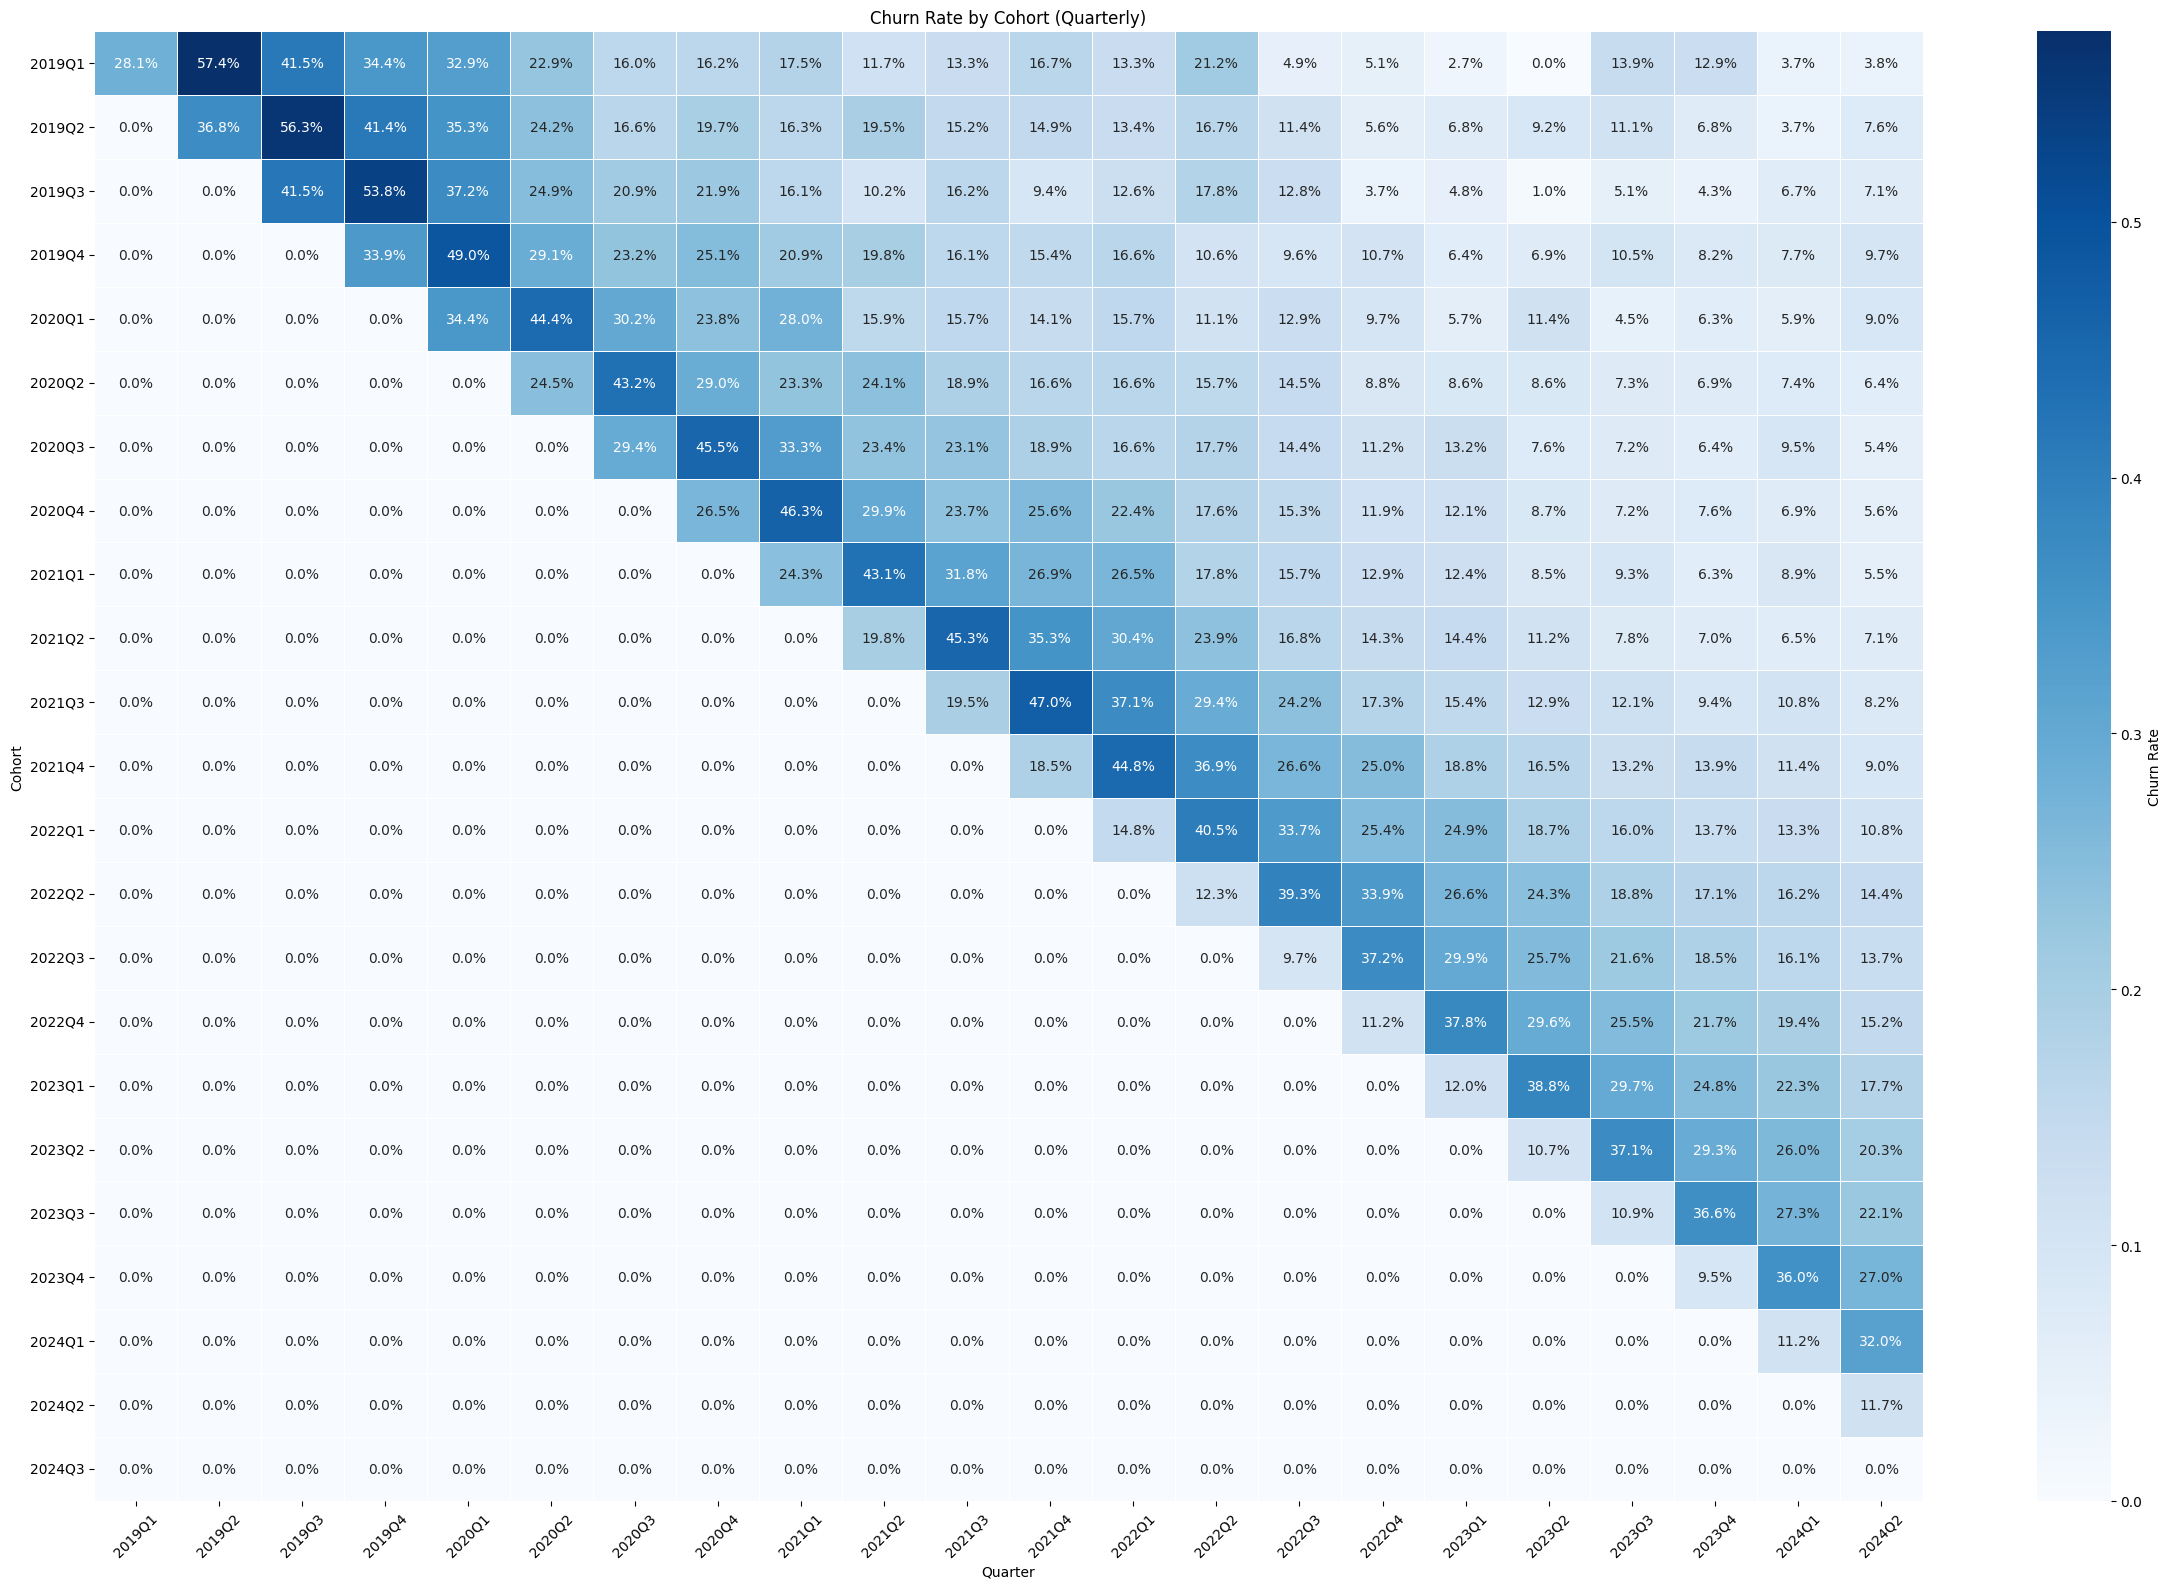

In [66]:
# Step 1: Add cohort column (quarter of first subscription)
final_df['cohort'] = final_df['from_date'].dt.to_period('Q')

# Step 2: Create a DataFrame to track the churn by cohort
cohort_data = []

# Generate a list of cohorts and quarters for comparison
quarters = pd.date_range(final_df['from_date'].min(), final_df['to_date'].max(), freq='Q').to_period('Q')

# Iterate over cohorts
for cohort in final_df['cohort'].unique():
    cohort_start_date = cohort.start_time
    cohort_subscriptions = final_df[final_df['cohort'] == cohort]
    
    for quarter in quarters:
        # Quarter of interest
        quarter_start = quarter.start_time
        quarter_end = quarter.end_time
        
        # Customers who started in this cohort (still active at the start of the quarter)
        cohort_customers = cohort_subscriptions[cohort_subscriptions['from_date'] <= quarter_end]
        
        # Customers who were active at the start of the quarter (not churned yet)
        active_customers_at_quarter_start = cohort_customers[cohort_customers['to_date'] >= quarter_start]
        
        # Customers in this cohort who churned (ended their subscription in this quarter)
        churned_customers = active_customers_at_quarter_start[active_customers_at_quarter_start['to_date'] <= quarter_end]
        
        # Calculate churn rate for this cohort in this quarter
        churn_rate = len(churned_customers) / len(active_customers_at_quarter_start) if len(active_customers_at_quarter_start) > 0 else 0
        
        cohort_data.append([cohort, quarter, churn_rate])

# Step 3: Convert to DataFrame for visualization
cohort_df = pd.DataFrame(cohort_data, columns=['Cohort', 'Quarter', 'Churn Rate'])

# Pivot table for easy visualization (rows = cohorts, columns = quarters)
cohort_pivot = cohort_df.pivot(index='Cohort', columns='Quarter', values='Churn Rate')

# Step 4: Plot the churn rates by cohort using a heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(cohort_pivot, annot=True, fmt='.1%', cmap='Blues', cbar_kws={'label': 'Churn Rate'}, linewidths=0.5)
plt.title('Churn Rate by Cohort (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Cohort')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

